In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv


In [2]:
torch.cuda.is_available()

True

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader

# Step 1: Generate a 1D Lattice Graph with 3 neighbors on each side
def create_1d_lattice_graph(lattice_size=149, neighbors=3):
    edges = []
    for i in range(lattice_size):
        edges.append([i, i])  # self loop
        for j in range(1, neighbors + 1):
            edges.append([i, (i - j) % lattice_size])  # Connect to left neighbors
            edges.append([i, (i + j) % lattice_size])  # Connect to right neighbors

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return edge_index

# Step 2: Define the GNN Model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        # First GCN layer + ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Second GCN layer
        x = self.conv2(x, edge_index)
        return x

def generate_data(lattice_size=149, sample_size=100000, prob=0.5):
    if prob < 0 or prob > 1:
        raise ValueError('Probability must be between 0 and 1.')
    
    edge_index = create_1d_lattice_graph(lattice_size=lattice_size)
    data_list = []
    
    for _ in range(sample_size):
        if prob == 0.5:
            # Generate random input states for each node
            x = torch.randint(0, 2, (lattice_size, 1), dtype=torch.float)
        elif prob == 0.0:
            # Generate all zeros
            x = torch.zeros(lattice_size, 1)
        elif prob == 1.0:
            # Generate all ones
            x = torch.ones(lattice_size, 1)
        else:
            x = torch.bernoulli(prob * torch.ones(lattice_size, 1))
        
        # Define the binary density classification based on the mean of cell states
        y = (x.mean() > 0.5).long().repeat(lattice_size)  # 0 for < 0.5 density, 1 for >= 0.5, repeated to match lattice size
        
        # Create a Data object and append to the list
        data_list.append(Data(x=x, edge_index=edge_index, y=y))
    
    return data_list

# Step 3: Create the data and model
lattice_size = 149
prob = 0.49
train_data_list = generate_data(lattice_size=lattice_size, sample_size=20000, prob=prob)
test_data_list = generate_data(lattice_size=lattice_size, sample_size=20000, prob=prob)

train_loader = DataLoader(train_data_list, batch_size=4098, shuffle=True)
test_loader = DataLoader(test_data_list, batch_size=4098, shuffle=False)

# Define model, optimizer, and loss function
model = GCN(input_dim=1, hidden_dim=32, output_dim=2)  # 2 for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.014)
criterion = torch.nn.CrossEntropyLoss()

# Step 4: Training Loop
def train(loader, model, optimizer, criterion, epochs=400, patience=20):
    model.train()
    recent_losses = []
    avg_loss_last=[]
    for epoch in range(epochs):
        total_loss = 0
        for data in loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)  # Forward pass
            loss = criterion(out, data.y)         # Compute the loss
            loss.backward()                       # Backpropagation
            optimizer.step()                      # Update the parameters
            total_loss += loss.item()
        
        avg_loss = total_loss / len(loader)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss}')
        
        # Early stopping if average loss over the last `patience` epochs doesn't reduce
        recent_losses.append(avg_loss)
        if len(recent_losses) > patience:
            avg_loss_last.append(sum(recent_losses) / len(recent_losses))
            recent_losses.pop(0)
            if len(avg_loss_last) > 1 and avg_loss_last[-2] < avg_loss_last[-1]:
                print(f'Early stopping at epoch {epoch+1}')
                break
            

# Step 5: Testing Loop
def test(loader, model):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    accuracy = correct / (len(loader.dataset) * lattice_size)
    print(f'Accuracy: {accuracy:.4f}')

# Train the model
train(train_loader, model, optimizer, criterion, epochs=400)

/home/BU/siyer5/Documents/GNN-for-DCT/.venv/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/400, Loss: 0.6827584981918335
Epoch 2/400, Loss: 0.6755966901779175
Epoch 3/400, Loss: 0.6689020037651062
Epoch 4/400, Loss: 0.6630343079566956
Epoch 5/400, Loss: 0.658139455318451
Epoch 6/400, Loss: 0.6550302267074585
Epoch 7/400, Loss: 0.6537573099136352
Epoch 8/400, Loss: 0.6544965744018555
Epoch 9/400, Loss: 0.6543773531913757
Epoch 10/400, Loss: 0.6543138504028321
Epoch 11/400, Loss: 0.6537298202514649
Epoch 12/400, Loss: 0.6538084268569946
Epoch 13/400, Loss: 0.6538097620010376
Epoch 14/400, Loss: 0.6539301156997681
Epoch 15/400, Loss: 0.6539788722991944
Epoch 16/400, Loss: 0.6537930250167847
Epoch 17/400, Loss: 0.6538020372390747


In [4]:

# Test the model
test(test_loader, model)

Accuracy: 0.8380


In [5]:
import matplotlib.pyplot as plt

probabilities = [i * 0.01 for i in range(101)]
accuracies = []

for prob in probabilities:
    sample_test_data = generate_data(lattice_size=lattice_size, sample_size=10000, prob=prob)
    sample_test_loader = DataLoader(sample_test_data, batch_size=4098, shuffle=False)
    correct = 0
    model.eval()
    for data in sample_test_loader:
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    accuracy = correct / (len(sample_test_loader.dataset) * lattice_size)
    accuracies.append(accuracy)


/home/BU/siyer5/Documents/GNN-for-DCT/.venv/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


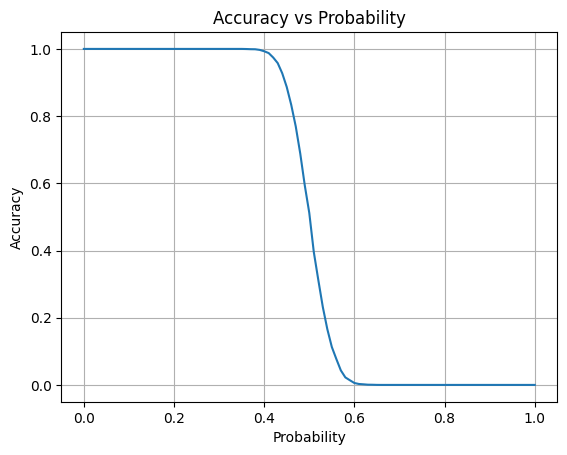

In [6]:

plt.plot(probabilities, accuracies)
plt.xlabel('Probability')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Probability')
plt.grid(True)
plt.show()

In [7]:
# sample = generate_data(lattice_size=149, sample_size=1)
# sample[0].y